## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/movielens/'

In [4]:
!ls {path}

links.csv  models  movies.csv  ratings.csv  README.txt	tags.csv  tmp


We're working with the movielens data, which contains one rating per row, like this:

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [7]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [43]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [51]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
%time learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 41.4 ms


In [14]:
cf

In [20]:
len(ratings), len(movies), len(val_idxs)

(100004, 9125, 20000)

In [25]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
len(ratings.groupby('userId'))

671

In [40]:
len(movies.groupby('movieId'))

9125

In [123]:
len(ratings.groupby('movieId').count())

9066

In [45]:
learn

EmbeddingDotBias (
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [52]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████   | 884/1251 [00:04<00:02, 178.98it/s, loss=4.77]


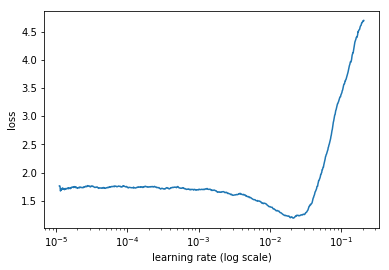

In [53]:
learn.sched.plot()

In [54]:
%time learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.84526  0.82863]                                    
[ 1.       0.66     0.93668]                                    
[ 2.       0.30057  0.89448]                                    

CPU times: user 22.3 s, sys: 4.46 s, total: 26.7 s
Wall time: 21.6 s


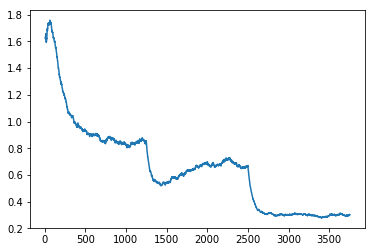

In [55]:
learn.sched.plot_loss()

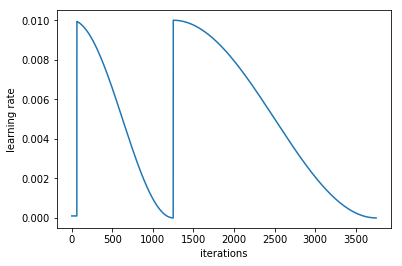

In [56]:
learn.sched.plot_lr()

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [57]:
math.sqrt(0.89448)

0.9457695279506525

In [58]:
## This looks different than notebook

In [60]:
preds = learn.predict()

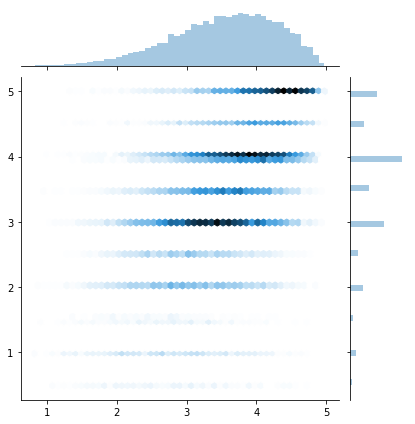

In [64]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [66]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [122]:
len(ratings.groupby('movieId')['rating'].count())

9066

In [67]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [76]:
## id to name mapping
#movie_names

In [75]:
print('movieId name')
for id, name in movie_names.items():
    print('{} {}'.format(id, name))
    break

movieId name
1 Toy Story (1995)


In [89]:
g.head()

movieId
1    247
2    107
3     59
4     13
5     56
Name: rating, dtype: int64

In [115]:
g.sort_values(ascending=False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [106]:
g.sort_values(ascending=False).index

Int64Index([   356,    296,    318,    593,    260,    480,   2571,      1,
               527,    589,
            ...
             26422,  26430,  26435,  26462,  26464,  26467,  26471,  26480,
             26485, 163949],
           dtype='int64', name='movieId', length=9066)

In [107]:
g.sort_values(ascending=False).index.values

array([   356,    296,    318, ...,  26480,  26485, 163949])

In [113]:
np.array([cf.item2idx[o] for o in topMovies])

array([  57,   49,   99, ...,  668, 4252, 4213])

In [116]:
m=learn.model; m

EmbeddingDotBias (
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [125]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [118]:
topMovieIdx[:5]

array([ 57,  49,  99,  92, 143])

In [124]:
m.ib(V(topMovieIdx[:5]))

Variable containing:
 0.7793
 0.8230
 1.1167
 0.8440
 0.7551
[torch.cuda.FloatTensor of size 5x1 (GPU 0)]

In [136]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

In [129]:
[(i, b) for i,b in zip(topMovies[:5],movie_bias[:5])

[(356, array([ 0.77934], dtype=float32)),
 (296, array([ 0.82304], dtype=float32)),
 (318, array([ 1.11669], dtype=float32)),
 (593, array([ 0.84399], dtype=float32)),
 (260, array([ 0.7551], dtype=float32))]

In [134]:
[(movie_names[i], b[0]) for i,b in zip(topMovies[:5],movie_bias[:5])]

[('Forrest Gump (1994)', 0.77933908),
 ('Pulp Fiction (1994)', 0.82304233),
 ('Shawshank Redemption, The (1994)', 1.1166852),
 ('Silence of the Lambs, The (1991)', 0.84398538),
 ('Star Wars: Episode IV - A New Hope (1977)', 0.75509918)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [143]:
sorted(movie_ratings, key=lambda x: x[0])[:5]

[(-0.80548936, 'Super Mario Bros. (1993)'),
 (-0.73008245, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.68448746, 'Bio-Dome (1996)'),
 (-0.67634869, 'Congo (1995)'),
 (-0.6697734, 'Speed 2: Cruise Control (1997)')]

In [142]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.80548936, 'Super Mario Bros. (1993)'),
 (-0.73008245, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.68448746, 'Bio-Dome (1996)'),
 (-0.67634869, 'Congo (1995)'),
 (-0.6697734, 'Speed 2: Cruise Control (1997)'),
 (-0.66653156, 'Wild Wild West (1999)'),
 (-0.66581583, 'Inspector Gadget (1999)'),
 (-0.66526103, 'Jingle All the Way (1996)'),
 (-0.66465974, 'Richie Rich (1994)'),
 (-0.65527999, 'Battlefield Earth (2000)'),
 (-0.64745486, 'Batman & Robin (1997)'),
 (-0.61910999, 'Dungeons & Dragons (2000)'),
 (-0.61674351, 'Johnny Mnemonic (1995)'),
 (-0.60429972, "Joe's Apartment (1996)"),
 (-0.60089654, 'Godzilla (1998)')]

In [84]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.96070349, 'Battlefield Earth (2000)'),
 (-0.76858485, 'Speed 2: Cruise Control (1997)'),
 (-0.73675376, 'Wild Wild West (1999)'),
 (-0.73655486, 'Anaconda (1997)'),
 (-0.72457194, 'Super Mario Bros. (1993)'),
 (-0.69564718, 'Congo (1995)'),
 (-0.67043746, 'Superman III (1983)'),
 (-0.64385736, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.62750411, "Joe's Apartment (1996)"),
 (-0.60154277, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.59929478, 'Batman & Robin (1997)'),
 (-0.59667748, 'Jaws 3-D (1983)'),
 (-0.5921765, 'Dungeons & Dragons (2000)'),
 (-0.59074384, 'Inspector Gadget (1999)'),
 (-0.57559621, 'Haunting, The (1999)')]

In [144]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.1166852, 'Shawshank Redemption, The (1994)'),
 (0.96424037, 'Godfather, The (1972)'),
 (0.92390549, "Schindler's List (1993)"),
 (0.88776302, 'Fargo (1996)'),
 (0.85633016, 'Usual Suspects, The (1995)'),
 (0.85295206, 'African Queen, The (1951)'),
 (0.84398538, 'Silence of the Lambs, The (1991)'),
 (0.83642733, '12 Angry Men (1957)'),
 (0.8326174, 'Godfather: Part II, The (1974)'),
 (0.82773715, 'Her (2013)'),
 (0.82755011, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.82304233, 'Pulp Fiction (1994)'),
 (0.79711473, 'To Kill a Mockingbird (1962)'),
 (0.79591626, 'Fight Club (1999)'),
 (0.7890864, 'Ideal Husband, An (1999)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [145]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [147]:
movie_emb.T.shape

(50, 3000)

In [149]:
movie_pca.shape

(3, 3000)

In [150]:
x = pca.fit(movie_emb.T)

In [152]:
x

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [153]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [154]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06406749, 'Godfather: Part II, The (1974)'),
 (0.061123442, 'Raging Bull (1980)'),
 (0.060424272, 'Godfather, The (1972)'),
 (0.05582723, 'Chinatown (1974)'),
 (0.052691575, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (0.05216936, 'On the Waterfront (1954)'),
 (0.050915852, 'Papillon (1973)'),
 (0.050827861, 'Best Years of Our Lives, The (1946)'),
 (0.048372194, 'When We Were Kings (1996)'),
 (0.048335169, 'Steamboat Willie (1928)')]

In [155]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.048598152, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.046513684, 'Home Alone 3 (1997)'),
 (-0.045534093, 'Eragon (2006)'),
 (-0.04467405, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.044447906, 'Jack Frost (1998)'),
 (-0.044011995, 'Anaconda (1997)'),
 (-0.042837434, 'Police Academy: Mission to Moscow (1994)'),
 (-0.042489212, 'Original Kings of Comedy, The (2000)'),
 (-0.040218655, 'Police Academy 3: Back in Training (1986)'),
 (-0.040044438, 'Karate Kid, Part III, The (1989)')]

In [156]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [157]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.062417474, 'Great Dictator, The (1940)'),
 (0.054983199, 'Shutter Island (2010)'),
 (0.053738847, 'In Bruges (2008)'),
 (0.051847111, 'American Werewolf in Paris, An (1997)'),
 (0.051694069, 'The Amazing Spider-Man 2 (2014)'),
 (0.051555816, 'Unbearable Lightness of Being, The (1988)'),
 (0.051021799, 'Talk to Her (Hable con Ella) (2002)'),
 (0.050935511, 'Jackie Brown (1997)'),
 (0.049334493, 'Slumdog Millionaire (2008)'),
 (0.04864065, 'Right Stuff, The (1983)')]

In [158]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.072888352, 'Amateur (1994)'),
 (-0.065193743, 'One False Move (1992)'),
 (-0.053718369, 'Clue (1985)'),
 (-0.053324044, '9 1/2 Weeks (Nine 1/2 Weeks) (1986)'),
 (-0.052652016,
  'Double Life of Veronique, The (Double Vie de Véronique, La) (1991)'),
 (-0.051180635, 'Happiness (1998)'),
 (-0.05071203, "Jumpin' Jack Flash (1986)"),
 (-0.048877686, 'Chef (2014)'),
 (-0.047553718, 'Piano Teacher, The (La pianiste) (2001)'),
 (-0.047547352, 'Constantine (2005)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

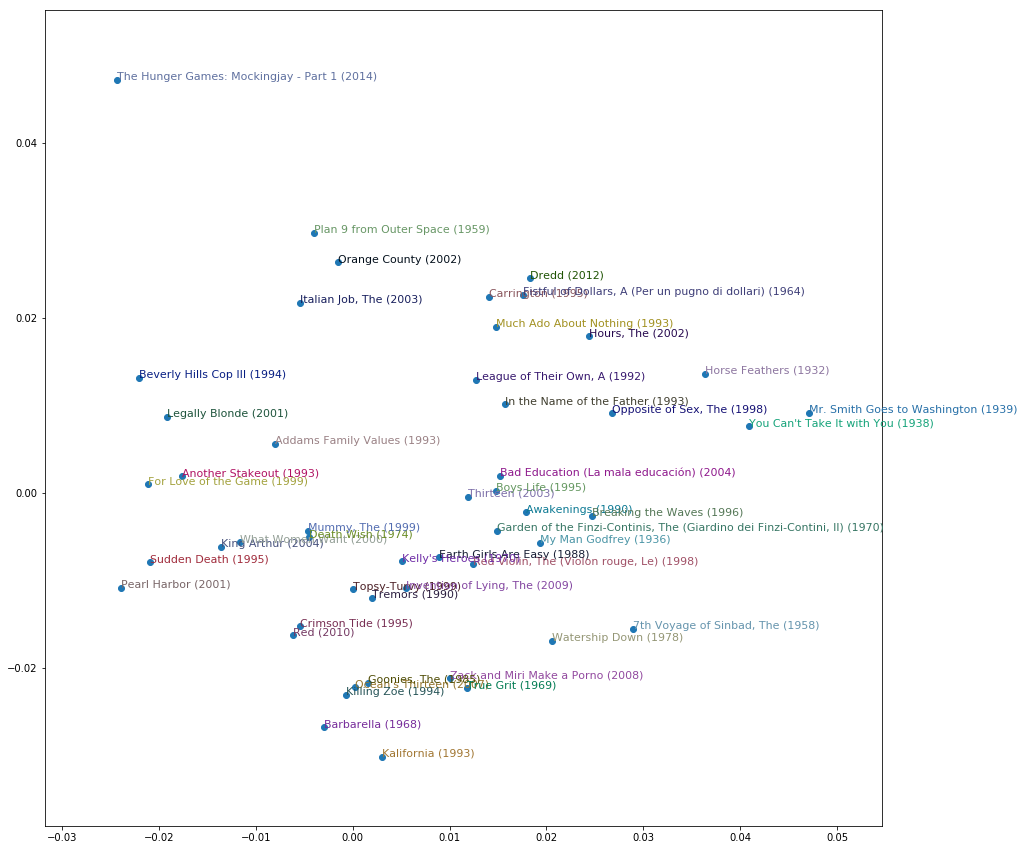

In [159]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [98]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [99]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [100]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [101]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [102]:
model=DotProduct()

In [103]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [11]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [12]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [13]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [14]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [15]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [16]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.      1.6368  1.6415]                                      
[ 1.       1.13749  1.29373]                                   
[ 2.       0.89736  1.22818]                                    



In [13]:
set_lrs(opt, 0.01)

In [14]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.69763  1.14979]                                    
[ 1.       0.70115  1.13657]                                    
[ 2.       0.66739  1.1303 ]                                    



### Bias

In [17]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [18]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [19]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [20]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88212  0.83626]                                    
[ 1.       0.8108   0.81831]                                    
[ 2.       0.78864  0.80989]                                    



In [47]:
set_lrs(opt, 1e-2)

In [48]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.72795  0.80337]                                    
[ 1.       0.75064  0.80203]                                    
[ 2.       0.75122  0.80124]                                    



### Mini net

In [49]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [54]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [51]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88043  0.82363]                                    
[ 1.       0.8941   0.81264]                                    
[ 2.       0.86179  0.80706]                                    



In [52]:
set_lrs(opt, 1e-3)

In [53]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.7669   0.78622]                                    
[ 1.       0.74277  0.78152]                                    
[ 2.       0.69891  0.78075]                                    

